# PBO learnt on several iterations and one weigth one the car on hill environment

## Define parameters

In [30]:
%load_ext autoreload
%autoreload 2

import numpy as np
import jax
import jax.numpy as jnp

# keys
seed = 55
key = jax.random.PRNGKey(seed)
sample_key, shuffle_key, q_network_key, random_weights_key, pbo_network_key = jax.random.split(key, 5)

gamma = 0.95

# Sample collection
n_actions = 2
oriented_state = jnp.array([0.5, 0.38])
n_random_samples = 3500
n_oriented_samples = 500
horizon_sample = 100
n_samples = n_random_samples + n_oriented_samples

# Weights collection
n_weights = 1

# Trainings
layers_dimension = (7, 7)
max_bellman_iterations = 15
batch_size_samples = n_samples

## Linear PBO
training_steps = 100
fitting_steps = 20
batch_size_weights = n_weights
learning_rate = {"first": 0.001, "last": 0.00005, "duration": training_steps * fitting_steps * n_samples // batch_size_samples}

## Q-learning
fitting_steps_q = fitting_steps * training_steps
learning_rate_q = {"first": 0.01, "last": 0.0005, "duration": fitting_steps_q * n_samples // batch_size_samples}

# Visualisation of errors and performances
n_states_x_visu = 23
n_states_v_visu = 17
margin_visu = 0.01
horizon = 70

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define environment

In [31]:
from pbo.environment.car_on_hill import CarOnHillEnv


max_pos = 1.0
max_velocity = 3.0
max_pos_margin_visu = max_pos - margin_visu
max_velocity_margin_visu = max_velocity - margin_visu

states_x_visu = jnp.linspace(-max_pos_margin_visu, max_pos_margin_visu, n_states_x_visu)
boxes_x_size = (2 * max_pos_margin_visu) / (n_states_x_visu - 1)
states_x_boxes = (np.linspace(-max_pos_margin_visu, max_pos_margin_visu + boxes_x_size, n_states_x_visu + 1) - boxes_x_size / 2)
states_v_visu = jnp.linspace(-max_velocity_margin_visu, max_velocity_margin_visu, n_states_v_visu)
boxes_v_size = (2 * max_velocity_margin_visu) / (n_states_v_visu - 1)
states_v_boxes = (np.linspace(-max_velocity_margin_visu, max_velocity_margin_visu + boxes_v_size, n_states_v_visu + 1) - boxes_v_size / 2)


env = CarOnHillEnv(max_pos, max_velocity, gamma)

## Collect samples

### Samples on the mesh and with a uniform policy

In [40]:
from pbo.sample_collection.replay_buffer import ReplayBuffer


replay_buffer = ReplayBuffer()

env.reset()
n_episodes = 0
n_steps = 0
for idx_sample in range(n_random_samples):
    state = env.state
    
    sample_key, key = jax.random.split(sample_key)
    if jax.random.uniform(key) > 0.5:
        action = jnp.array([0])
    else:
        action = jnp.array([1])
    next_state, reward, absorbing, _ = env.step(action)
    n_steps += 1

    replay_buffer.add(state, action, reward, next_state, absorbing)

    if absorbing or n_steps > horizon_sample:
        env.reset()
        n_episodes += 1
        n_steps = 0


env.reset(oriented_state)
n_episodes += 1
n_steps = 0
for idx_sample in range(n_oriented_samples):
    state = env.state
    
    sample_key, key = jax.random.split(sample_key)
    if jax.random.uniform(key) > 0.5:
        action = jnp.array([0])
    else:
        action = jnp.array([1])
    next_state, reward, absorbing, _ = env.step(action)
    n_steps += 1

    replay_buffer.add(state, action, reward, next_state, absorbing)

    if absorbing or n_steps > horizon_sample:
        sample_key, key = jax.random.split(sample_key)
        env.reset(jax.random.normal(key, (2,)) / 2 + oriented_state)

        n_episodes += 1
        n_steps = 0

replay_buffer.cast_to_jax_array()
assert sum(replay_buffer.rewards == 1) > 0, "No positive reward has been sampled, please do something!"
print(f"Number of episodes: {n_episodes}")

Number of episodes: 93


In [41]:
replay_buffer.actions[(replay_buffer.rewards == 1).flatten()]

DeviceArray([[0],
             [1],
             [1],
             [0],
             [0],
             [1],
             [1],
             [0],
             [1],
             [1],
             [1],
             [0],
             [1]], dtype=int32)

### Visualize samples

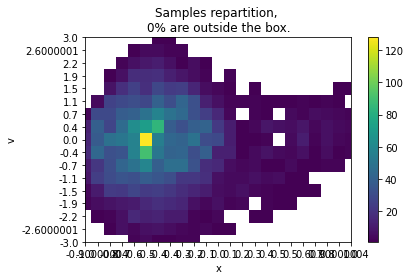

In [42]:
from pbo.sample_collection.count_samples import count_samples
from pbo.utils.two_dimesions_mesh import TwoDimesionsMesh


samples_count, n_outside_boxes, rewards_count = count_samples(replay_buffer.states[:, 0], replay_buffer.states[:, 1], states_x_boxes, states_v_boxes, replay_buffer.rewards)
samples_visu_mesh = TwoDimesionsMesh(states_x_visu, states_v_visu, sleeping_time=0, axis_equal=False)

samples_visu_mesh.set_values(samples_count, zeros_to_nan=True)
samples_visu_mesh.show(
    f"Samples repartition, \n{int(100 * n_outside_boxes / n_samples)}% are outside the box.", xlabel="x", ylabel="v"
)

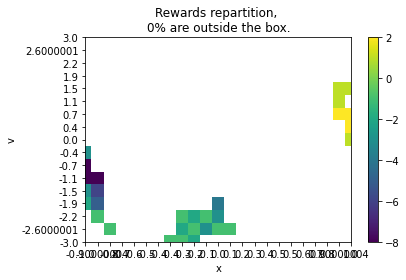

In [43]:
samples_visu_mesh.set_values(rewards_count, zeros_to_nan=True)
samples_visu_mesh.show(
    f"Rewards repartition, \n{int(100 * n_outside_boxes / n_samples)}% are outside the box.", xlabel="x", ylabel="v"
)

## Train Q with Fitted-Q with enough power to make it working

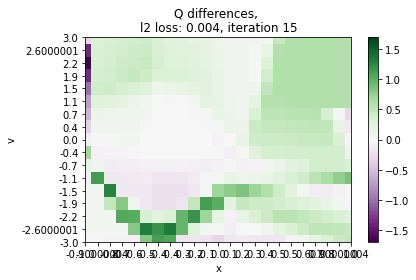

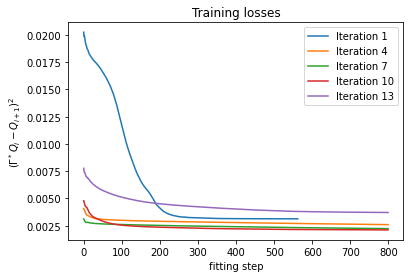

In [44]:
import matplotlib.pyplot as plt

from pbo.sample_collection.dataloader import SampleDataLoader
from pbo.networks.learnable_q import FullyConnectedQ


max_bellman_iterations_best = 15
fitting_steps_q_best = 800
batch_size_samples = n_samples

data_loader_samples = SampleDataLoader(replay_buffer, batch_size_samples, shuffle_key)
q_best = FullyConnectedQ(
    state_dim=2,
    action_dim=1,
    continuous_actions=False,
    n_actions_on_max=n_actions,
    action_range_on_max=None,
    gamma=gamma,
    network_key=q_network_key,
    random_weights_range=None,
    random_weights_key=random_weights_key,
    learning_rate={"first": 0.01, "last": 0.0005, "duration": fitting_steps_q_best},
    layers_dimension=layers_dimension,
    zero_initializer=True,
)

q_visu_mesh = TwoDimesionsMesh(states_x_visu, states_v_visu, sleeping_time=0, axis_equal=False, zero_centered=True)
l2_losses = np.ones((max_bellman_iterations_best, fitting_steps_q_best)) * np.nan

for bellman_iteration in range(max_bellman_iterations_best):
    params_target = q_best.params
    best_loss = float('inf')
    patience = 0

    for step in range(fitting_steps_q_best):
        cumulative_l2_loss = 0
        
        data_loader_samples.shuffle()
        for batch_samples in data_loader_samples:
            # sort = batch_samples["state"][:, 0] > 0.1

            # batch_samples = {
            #     "state": batch_samples["state"][sort],
            #     "action": batch_samples["action"][sort],
            #     "reward": batch_samples["reward"][sort],
            #     "absorbing": batch_samples["absorbing"][sort],
            #     "next_state": batch_samples["next_state"][sort]
            # }
            q_best.params, q_best.optimizer_state, l2_loss = q_best.learn_on_batch(q_best.params, params_target, q_best.optimizer_state, batch_samples)
            cumulative_l2_loss += l2_loss

        l2_losses[bellman_iteration, step] = cumulative_l2_loss
        if cumulative_l2_loss / best_loss * 100 < 99.999:
            patience = 0
            best_loss = cumulative_l2_loss
        else:
            patience += 1
        
        if patience > 5:
            break

    diff_q = env.diff_q_mesh(q_best, states_x_visu, states_v_visu)

    q_visu_mesh.set_values(diff_q)
    q_visu_mesh.show(f"Q differences, \nl2 loss: {str(jnp.round(cumulative_l2_loss, 3))}, iteration {bellman_iteration + 1}", xlabel="x", ylabel="v")


for bellman_iteration in range(0, max_bellman_iterations_best, max(max_bellman_iterations_best // 5, 1)):
    plt.plot(l2_losses[bellman_iteration], label=f"Iteration {bellman_iteration + 1}")

plt.legend()
plt.xlabel("fitting step")
plt.ylabel(r"$(\Gamma^*Q_i - Q_{i +  1})^2$")
plt.title("Training losses")
plt.show()

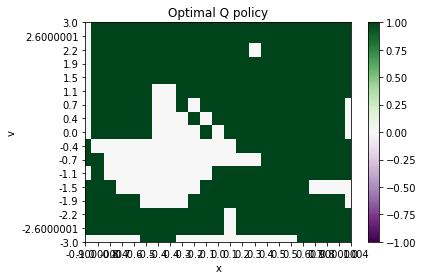

In [45]:
best_diff_q = env.diff_q_mesh(q_best, states_x_visu, states_v_visu)

q_visu_mesh.set_values((best_diff_q > 0).astype(float))
q_visu_mesh.show("Optimal Q policy", xlabel="x", ylabel="v")

In [46]:
env.simulate(q_best, horizon, jnp.array([-0.5, 0]))

[-0.5  0. ]
[0.01339006]
[0.01339006]

[-0.4803309  0.3866922]
[0.01339006]
[0.01339006]

[-0.4254183  0.690585 ]
[0.01339006]
[0.01339006]

[-0.34757635  0.83584267]
[0.01339006]
[0.01339006]

[-0.2641553   0.80664194]
[0.01339006]
[0.01926568]

[-0.19029287  0.65616035]
[0.01339006]
[0.01282422]

[-0.16202872 -0.08472178]
[0.01339006]
[0.01339006]

[-0.17941204 -0.26082817]
[0.01339006]
[0.01339006]

[-0.21348742 -0.41545555]
[0.01339006]
[0.01339006]

[-0.2610239  -0.52539074]
[0.0295011]
[0.01339006]

[-0.35038307 -1.2620022 ]
[0.22797468]
[0.02976292]

[-0.5091827 -1.8552728]
[0.41406268]
[0.23729654]

[-0.7020907 -1.8970759]
[-0.23631772]
[0.5054866]

[-0.8460443 -1.0027244]
[0.5739152]
[0.44082528]

[-0.9315861  -0.70456445]
[-0.24716328]
[0.49028128]

[-0.9654018   0.01829866]
[0.4515145]
[0.4780635]

[-0.9278176  0.7444558]
[0.4057382]
[0.5429804]

[-0.8121066  1.601793 ]
[0.36227864]
[0.777947]

[-0.60216343  2.5831828 ]
[0.5102091]
[0.923198]

[-0.32200387  2.7908404 ]
[0.53

DeviceArray([ True], dtype=bool)

## Train Q with Fitted-Q

In [39]:
import matplotlib.pyplot as plt

from pbo.sample_collection.dataloader import SampleDataLoader
from pbo.networks.learnable_q import FullyConnectedQ


data_loader_samples = SampleDataLoader(replay_buffer, batch_size_samples, shuffle_key)
q = FullyConnectedQ(
    state_dim=2,
    action_dim=1,
    continuous_actions=False,
    n_actions_on_max=n_actions,
    action_range_on_max=None,
    gamma=gamma,
    network_key=q_network_key,
    random_weights_range=None,
    random_weights_key=random_weights_key,
    learning_rate=learning_rate_q,
    layers_dimension=layers_dimension,
    zero_initializer=True,
)

l2_losses = np.zeros((max_bellman_iterations, fitting_steps_q))

for bellman_iteration in range(max_bellman_iterations):
    params_target = q.params

    for step in range(fitting_steps_q):
        cumulative_l2_loss = 0
        
        data_loader_samples.shuffle()
        for batch_samples in data_loader_samples:
            q.params, q.optimizer_state, l2_loss = q.learn_on_batch(q.params, params_target, q.optimizer_state, batch_samples)
            cumulative_l2_loss += l2_loss

        l2_losses[bellman_iteration, step] = cumulative_l2_loss

    diff_q = env.diff_q_mesh(q, states_x_visu, states_v_visu)

    q_visu_mesh.set_values(diff_q)
    q_visu_mesh.show(f"Q differences, \nl2 loss: {str(jnp.round(cumulative_l2_loss, 3))}, iteration {bellman_iteration + 1}", xlabel="x", ylabel="v")



for bellman_iteration in range(max_bellman_iterations):
    plt.plot(l2_losses[bellman_iteration], label=f"Iteration {bellman_iteration + 1}")

plt.legend()
plt.xlabel("fitting step")
plt.ylabel(r"$(\Gamma^*Q_i - Q_{i +  1})^2$")
plt.title("Training losses")
plt.show()

KeyboardInterrupt: 

In [ ]:
diff_q = env.diff_q_mesh(q, states_x_visu, states_v_visu)

q_visu_mesh.set_values((diff_q > 0).astype(float))
q_visu_mesh.show("Q policy", xlabel="x", ylabel="v")

In [ ]:
q_visu_mesh.set_values(best_diff_q - diff_q)
q_visu_mesh.show(f"Optimal Q differences - Q differences,\nIf high, Q should go more confident to go to the right.", xlabel="x", ylabel="v")

In [ ]:
env.simulate(q, horizon, jnp.array([-0.5, 0]))

## Collect weights

In [47]:
from pbo.weights_collection.weights_buffer import WeightsBuffer


weights_buffer = WeightsBuffer()

# Add randow weights
q_pbo = FullyConnectedQ(
    state_dim=2,
    action_dim=1,
    continuous_actions=False,
    n_actions_on_max=n_actions,
    action_range_on_max=None,
    gamma=gamma,
    network_key=q_network_key,
    random_weights_range=None,
    random_weights_key=random_weights_key,
    learning_rate=None,
    layers_dimension=layers_dimension,
    zero_initializer=True,
)

while len(weights_buffer) < n_weights:
    weights = q_pbo.random_init_weights()
    weights_buffer.add(weights)

weights_buffer.cast_to_jax_array()

## Train linear PBO

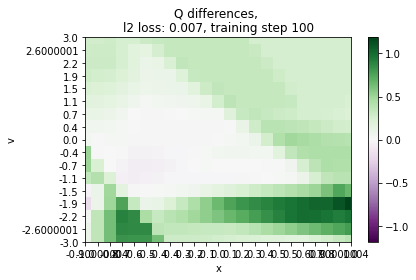

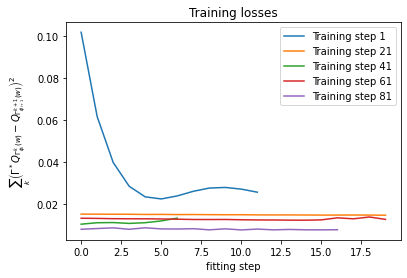

In [51]:
from pbo.sample_collection.dataloader import SampleDataLoader
from pbo.weights_collection.dataloader import WeightsDataLoader
from pbo.networks.learnable_pbo import LinearPBO


data_loader_samples = SampleDataLoader(replay_buffer, batch_size_samples, shuffle_key)
data_loader_weights = WeightsDataLoader(weights_buffer, batch_size_weights, shuffle_key)
pbo = LinearPBO(q_pbo, max_bellman_iterations, False, pbo_network_key, learning_rate)  # add_infinity == True
importance_iteration = jnp.ones(max_bellman_iterations + 1)

l2_losses = np.ones((training_steps, fitting_steps)) * np.nan

for training_step in range(training_steps):
    params_target = pbo.params
    best_loss = float('inf')
    patience = 0

    for fitting_step in range(fitting_steps):
        cumulative_l2_loss = 0

        data_loader_weights.shuffle()
        for batch_weights in data_loader_weights:
            data_loader_samples.shuffle()
            for batch_samples in data_loader_samples:
                pbo.params, pbo.optimizer_state, l2_loss = pbo.learn_on_batch(
                    pbo.params, params_target, pbo.optimizer_state, batch_weights, batch_samples, importance_iteration
                )
                cumulative_l2_loss += l2_loss
        
        l2_losses[training_step, fitting_step] = cumulative_l2_loss
        if cumulative_l2_loss / best_loss * 100 < 99.99:
            patience = 0
            best_loss = cumulative_l2_loss
        else:
            patience += 1

        if patience > 5:
            break

    if not pbo.add_infinity:
        q_weight = data_loader_weights.weights[0]
        for _ in range(max_bellman_iterations):
            q_weight = pbo(pbo.params, q_weight)
    else:
        q_weight = pbo.fixed_point(pbo.params)
    q_pbo.params = q_pbo.to_params(q_weight)
    diff_q_pbo = env.diff_q_mesh(q_pbo, states_x_visu, states_v_visu)

    q_visu_mesh.set_values(diff_q_pbo)
    q_visu_mesh.show(f"Q differences, \nl2 loss: {str(jnp.round(cumulative_l2_loss, 3))}, training step {training_step + 1}", xlabel="x", ylabel="v")


for training_step in range(0, training_steps, max(training_steps // 5, 1)):
    plt.plot(l2_losses[training_step], label=f"Training step {training_step + 1}")

plt.legend()
plt.xlabel("fitting step")
plt.ylabel(r"$\sum_{k} \left(\Gamma^*Q_{\Gamma_{\phi_i}^k(w)} - Q_{\Gamma_{\phi_{i + 1}}^{k + 1}(w)} \right)^2$")
plt.title("Training losses")
plt.show()

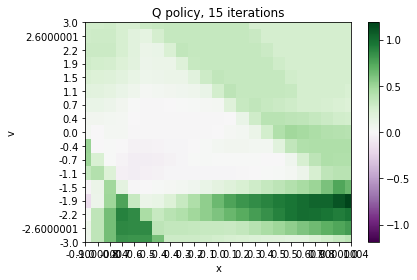

In [52]:
if not pbo.add_infinity:
    test_bellman_iterations = max_bellman_iterations

    q_weight = data_loader_weights.weights[0]
    for _ in range(test_bellman_iterations):
        q_weight = pbo(pbo.params, q_weight)
else:
    test_bellman_iterations = float("inf")
    q_weight = pbo.fixed_point(pbo.params)

q_pbo.params = q_pbo.to_params(q_weight)

diff_q_pbo = env.diff_q_mesh(q_pbo, states_x_visu, states_v_visu)

q_visu_mesh = TwoDimesionsMesh(states_x_visu, states_v_visu, sleeping_time=0, axis_equal=False, zero_centered=True)

q_visu_mesh.set_values(diff_q_pbo)
q_visu_mesh.show(f"Q policy, {test_bellman_iterations} iterations", xlabel="x", ylabel="v")

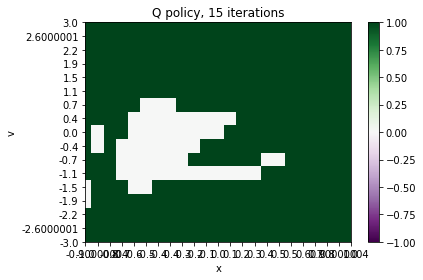

In [53]:
q_visu_mesh.set_values((diff_q_pbo > 0).astype(float))
q_visu_mesh.show(f"Q policy, {test_bellman_iterations} iterations", xlabel="x", ylabel="v")

In [55]:
env.simulate(q_pbo, horizon, jnp.array([-0.5, 0]))

[-0.5  0. ]
[0.12042254]
[0.10320354]

[-0.5196691 -0.3866922]
[0.14975378]
[0.11196759]

[-0.57458174 -0.69058496]
[0.18366998]
[0.12068418]

[-0.6524237  -0.83584255]
[0.20392829]
[0.13181058]

[-0.73584473 -0.8066418 ]
[0.21199712]
[0.1793187]

[-0.80970716 -0.6561602 ]
[0.21147968]
[0.21298924]

[-0.8379713   0.08472195]
[0.18737862]
[0.21571384]

[-0.79239184  0.83640504]
[0.17120883]
[0.26837605]

[-0.6681012  1.6570239]
[0.1355493]
[0.29338393]

[-0.46682808  2.2751522 ]
[0.18145743]
[0.27461976]

[-0.24085198  2.121697  ]
[0.18503222]
[0.5277628]

[-0.05408749  1.6044002 ]
[0.17372227]
[0.52699775]

[0.08628011 1.2741613 ]
[0.21383676]
[0.5575086]

[0.2062369 1.1392648]
[0.33672023]
[0.6618025]

[0.31660053 1.0807475 ]
[0.4674986]
[0.7925809]

[0.425263 1.10823 ]
[0.6414432]
[0.96652555]

[0.5414516 1.2311448]
[0.8770938]
[1.1874344]

[0.6743681 1.4400225]
[1.1001247]
[1.3546036]

[0.8316725 1.7153956]
[1.3085576]
[1.5630366]



DeviceArray([ True], dtype=bool)